**Script Description** This script loads a pre-processed dataset, prepares features and target variables to perform Shapely Analysis of the selected features.

**File Name:** 02_04_Feature_Selec_SHAP_Analysis.ipynb

**Date**: 2025

**Created by**: Rob Alamgir

##### Import the relevant packages

In [1]:
import numpy as np
import pandas as pd
import shap
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 

### Step 1: Load and preprocess the dataset

In [2]:
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data_Final/Pre_Processed_Data_All_Locations_V6.csv"
complete_dataset = pd.read_csv(data_path)

column_to_remove = 'Porosity'  
complete_dataset = complete_dataset.drop(columns=[column_to_remove])
rename_dict = {"Porosity_BIS4D_SOM": "Porosity","BOFEK_2020_Physical Units": "BOFEK_PU", "Peat_Thickness_2022": "Peat_Thickness"}
complete_dataset.rename(columns=rename_dict, inplace=True)

# Data preprocessing
complete_dataset['Date'] = pd.to_datetime(complete_dataset['Date'], format='%Y-%m-%d')
complete_dataset['Source_ID'] = complete_dataset['Site_ID'].astype('category').cat.codes + 1
print(f"Rows and columns before removing NaNs: {complete_dataset.shape}")
filtered_df = complete_dataset.dropna(subset=['SENTEK_SMC']).copy()
filtered_df['BOFEK_PU'] = filtered_df['BOFEK_PU'].astype('category')
print(f"Rows and columns after removing NaNs: {filtered_df.shape}")

SBFS_Features = ['Sentinel_1_SMC', 'S1_Backscatter', 'S1_Backscatter_SD', 'S2_NDVI', 'S2_NDMI', 'L8_9_LST', 
                 'WLEV_f', 'WTMP_f', 'PET', 'Peat_Thickness'] 

Hyperparamters = {'n_estimators' : 800,
                  'max_depth' : 5,
                  'learning_rate' : 0.01,
                  'subsample' : 0.8, 
                  'colsample_bytree' : 0.5,
                  'enable_categorical': True}

X = filtered_df[SBFS_Features]    # Features   
y = filtered_df['SENTEK_SMC']     # Predictor
groups = filtered_df["Source_ID"] # Groups for Leave-One-Group-Out
dates = filtered_df['Date']
print(f"Features (X): {X.shape}, Target (y): {y.shape}, Groups: {groups.shape}, Date: {dates.shape}")

Rows and columns before removing NaNs: (36056, 109)
Rows and columns after removing NaNs: (8368, 109)
Features (X): (8368, 10), Target (y): (8368,), Groups: (8368,), Date: (8368,)


In [3]:
#X100 = shap.utils.sample(X, 100) # Sample 100 instances from the dataset for SHAP analysis
X200 = shap.utils.sample(X, 200)  # Sample 200 instances from the dataset for SHAP analysis

model_xgb = XGBRegressor(n_estimators = Hyperparamters['n_estimators'],
                         max_depth = Hyperparamters['max_depth'],
                         learning_rate = Hyperparamters['learning_rate'], 
                         subsample = Hyperparamters['subsample'],
                         colsample_bytree = Hyperparamters['colsample_bytree'],
                         enable_categorical = True
                        ).fit(X, y) 

# Initialize a SHAP TreeExplainer with the trained model and sampled data
explainer_xgb = shap.TreeExplainer(model_xgb, X200)
shap_values_xgb = explainer_xgb(X)              # Calculate SHAP values 

base_values = explainer_xgb.expected_value     # Model's expected output as baseline
feature_data = X.values                        # Feature data for each instance
feature_names = X.columns.tolist()             # List of feature names

# Construct the shap.Explanation object
shap_values_explanation = shap.Explanation(
    values=shap_values_xgb,                       # SHAP values from explainer
    base_values=base_values,                      # Expected base value from explainer
    data=feature_data,                            # Feature data (input values)
    feature_names=feature_names)                  # Feature names

100%|===================| 8340/8368 [04:23<00:00]        

### Plot Beeswarm plot

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Beeswarm_plot.png


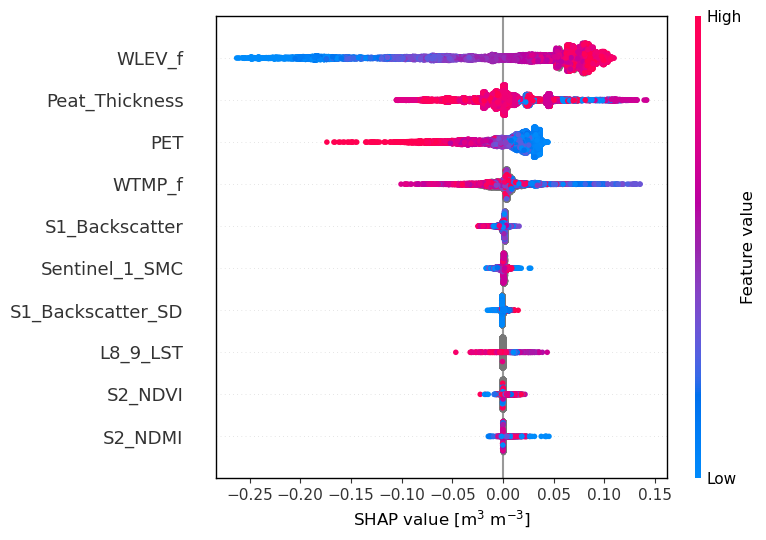

In [11]:
shap.plots.beeswarm(shap_values_explanation, show=False)
ax = plt.gca()  
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
plt.xlabel("SHAP value [m$^{3}$ m$^{-3}$]", fontsize=12)
plt.tight_layout()
save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Beeswarm_plot.png"  
#ax.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
#plt.show()

### SHAP scatter plots of remotely sensed features

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/SHAP_scatter_RSD.png


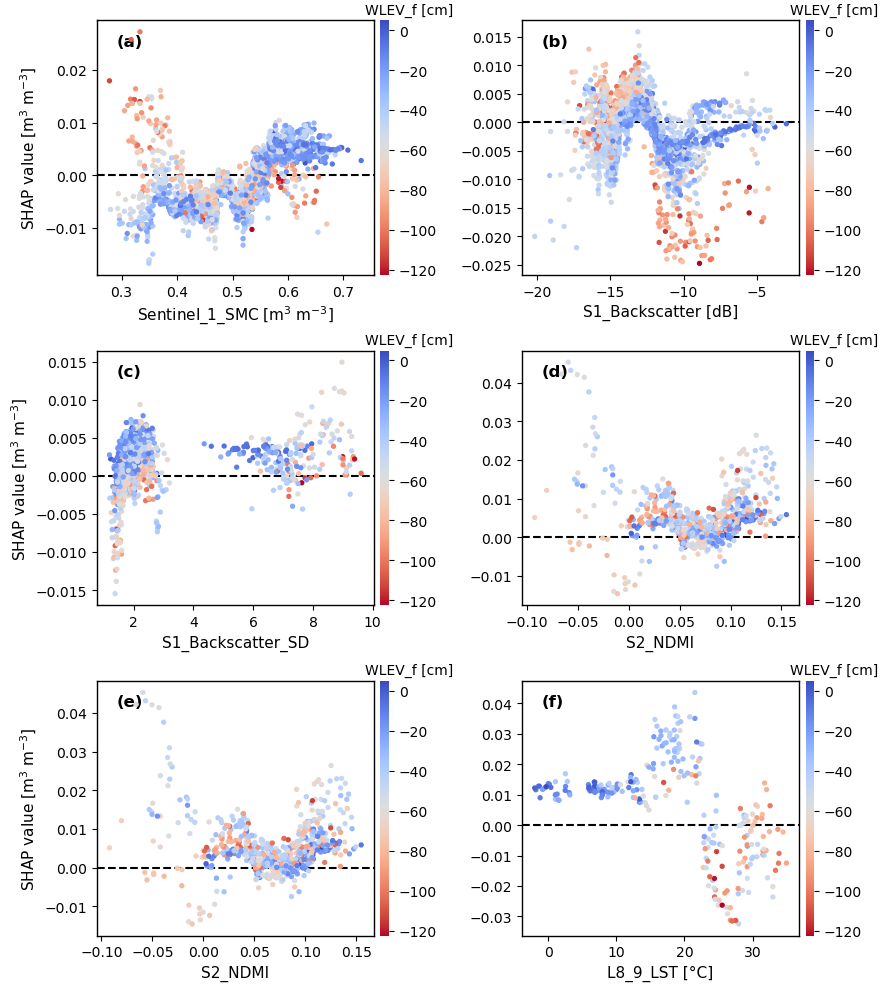

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(9, 10))

# ---------------- AX1 ----------------
scatter1 = ax1.scatter(
    shap_values_explanation[:, 'Sentinel_1_SMC'].data,
    shap_values_explanation[:, 'Sentinel_1_SMC'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5,
)
cbar1 = plt.colorbar(scatter1, ax=ax1, aspect=30, pad=0.02)
cbar1.set_label("WLEV_f [cm]", fontsize=10)
cbar1.ax.yaxis.label.set_rotation(360)  
cbar1.ax.yaxis.labelpad = -20  
cbar1.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar1.outline.set_visible(False)
ax1.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax1.set_xlabel('Sentinel_1_SMC [m$^{3}$ m$^{-3}$]', fontsize=11)
ax1.set_ylabel('SHAP value [m$^3$ m$^{-3}$]', fontsize=11)
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax1.text(0.07, 0.9, '(a)', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes, size=12)

# ---------------- AX2 ----------------
scatter2 = ax2.scatter(
    shap_values_explanation[:, 'S1_Backscatter'].data,
    shap_values_explanation[:, 'S1_Backscatter'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5
)
cbar2 = plt.colorbar(scatter1, ax=ax2, aspect=30, pad=0.02)
cbar2.set_label("WLEV_f [cm]", fontsize=10)
cbar2.ax.yaxis.label.set_rotation(360)  
cbar2.ax.yaxis.labelpad = -20  
cbar2.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar2.outline.set_visible(False)

ax2.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax2.set_xlabel('S1_Backscatter [dB]', fontsize=11)
ax2.set_ylabel('')
for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax2.text(0.07, 0.9, '(b)', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes, size=12)

# ---------------- AX3 ----------------
scatter3 = ax3.scatter(
    shap_values_explanation[:, 'S1_Backscatter_SD'].data,
    shap_values_explanation[:, 'S1_Backscatter_SD'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5
)
cbar3 = plt.colorbar(scatter1, ax=ax3, aspect=30, pad=0.02)
cbar3.set_label("WLEV_f [cm]", fontsize=10)
cbar3.ax.yaxis.label.set_rotation(360)  
cbar3.ax.yaxis.labelpad = -20  
cbar3.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar3.outline.set_visible(False)

ax3.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax3.set_xlabel('S1_Backscatter_SD', fontsize=11)
ax3.set_ylabel('SHAP value [m$^3$ m$^{-3}$]', fontsize=11)
for spine in ax3.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax3.text(0.07, 0.9, '(c)', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes, size=12)

# ---------------- AX4 ----------------
scatter4 = ax4.scatter(
    shap_values_explanation[:, 'S2_NDMI'].data,
    shap_values_explanation[:, 'S2_NDMI'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5
)
cbar4 = plt.colorbar(scatter1, ax=ax4, aspect=30, pad=0.02)
cbar4.set_label("WLEV_f [cm]", fontsize=10)
cbar4.ax.yaxis.label.set_rotation(360)  
cbar4.ax.yaxis.labelpad = -20  
cbar4.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar4.outline.set_visible(False)

ax4.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax4.set_xlabel('S2_NDMI', fontsize=11)
ax4.set_ylabel('')
for spine in ax4.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax4.text(0.07, 0.9, '(d)', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes, size=12)

# ---------------- AX5 ----------------
scatter5 = ax5.scatter(
    shap_values_explanation[:, 'S2_NDMI'].data,
    shap_values_explanation[:, 'S2_NDMI'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5
)
cbar5 = plt.colorbar(scatter1, ax=ax5, aspect=30, pad=0.02)
cbar5.set_label("WLEV_f [cm]", fontsize=10)
cbar5.ax.yaxis.label.set_rotation(360)  
cbar5.ax.yaxis.labelpad = -20  
cbar5.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar5.outline.set_visible(False)

ax5.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax5.set_xlabel('S2_NDMI', fontsize=11)
ax5.set_ylabel('SHAP value [m$^3$ m$^{-3}$]', fontsize=11)
for spine in ax5.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax5.text(0.07, 0.9, '(e)', fontdict={'fontweight': 'bold'}, transform=ax5.transAxes, size=12)

# ---------------- AX6 ----------------
scatter6 = ax6.scatter(
    shap_values_explanation[:, 'L8_9_LST'].data,
    shap_values_explanation[:, 'L8_9_LST'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5
)
cbar6 = plt.colorbar(scatter1, ax=ax6, aspect=30, pad=0.02)
cbar6.set_label("WLEV_f [cm]", fontsize=10)
cbar6.ax.yaxis.label.set_rotation(360)  
cbar6.ax.yaxis.labelpad = -20  
cbar6.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar6.outline.set_visible(False)

ax6.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax6.set_xlabel('L8_9_LST [°C]', fontsize=11)
ax6.set_ylabel('')
for spine in ax6.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax6.text(0.07, 0.9, '(f)', fontdict={'fontweight': 'bold'}, transform=ax6.transAxes, size=12)

plt.tight_layout()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/SHAP_scatter_RSD.png"  
#fig.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

### SHAP scatter plots of ground sensed features

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/SHAP_scatter_GSD.png


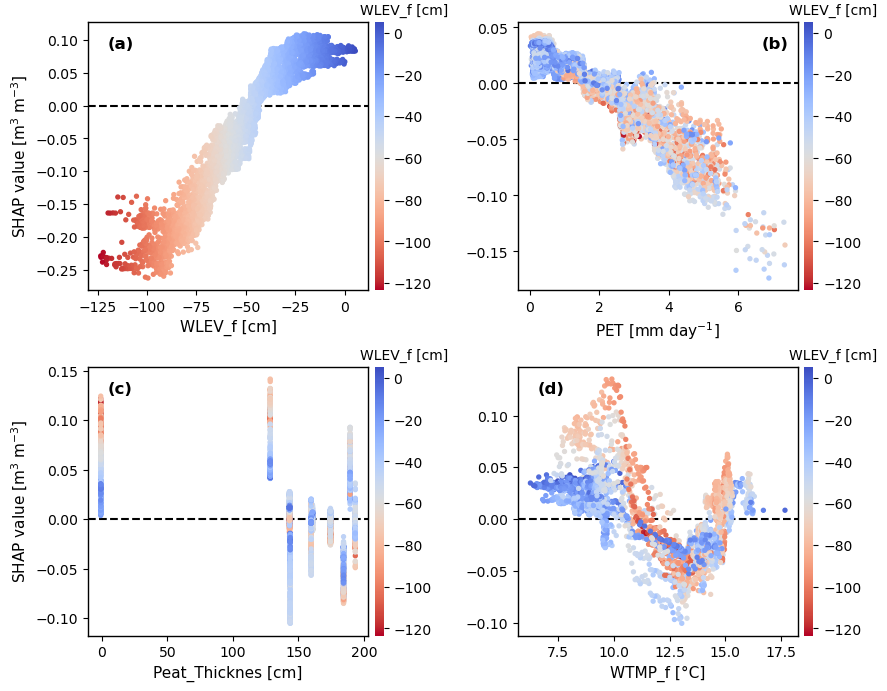

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 7))
# ---------------- AX1 ----------------
scatter1 = ax1.scatter(
    shap_values_explanation[:, 'WLEV_f'].data,
    shap_values_explanation[:, 'WLEV_f'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5,
)
cbar1 = plt.colorbar(scatter1, ax=ax1, aspect=30, pad=0.02)
cbar1.set_label("WLEV_f [cm]", fontsize=10)
cbar1.ax.yaxis.label.set_rotation(360)  
cbar1.ax.yaxis.labelpad = -20  
cbar1.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar1.outline.set_visible(False)
ax1.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax1.set_xlabel('WLEV_f [cm]', fontsize=11)
ax1.set_ylabel('SHAP value [m$^3$ m$^{-3}$]', fontsize=11)
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax1.text(0.07, 0.9, '(a)', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes, size=12)

# ---------------- AX2 ----------------
scatter2 = ax2.scatter(
    shap_values_explanation[:, 'PET'].data,
    shap_values_explanation[:, 'PET'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5
)
cbar2 = plt.colorbar(scatter1, ax=ax2, aspect=30, pad=0.02)
cbar2.set_label("WLEV_f [cm]", fontsize=10)
cbar2.ax.yaxis.label.set_rotation(360)  
cbar2.ax.yaxis.labelpad = -20  
cbar2.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar2.outline.set_visible(False)

ax2.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax2.set_xlabel('PET [mm day$^{-1}$]', fontsize=11)
ax2.set_ylabel('')
for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax2.text(0.87, 0.9, '(b)', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes, size=12)

# ---------------- AX3 ----------------
scatter3 = ax3.scatter(
    shap_values_explanation[:, 'Peat_Thickness'].data,
    shap_values_explanation[:, 'Peat_Thickness'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5
)
cbar3 = plt.colorbar(scatter1, ax=ax3, aspect=30, pad=0.02)
cbar3.set_label("WLEV_f [cm]", fontsize=10)
cbar3.ax.yaxis.label.set_rotation(360)  
cbar3.ax.yaxis.labelpad = -20  
cbar3.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar3.outline.set_visible(False)

ax3.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax3.set_xlabel('Peat_Thicknes [cm]', fontsize=11)
ax3.set_ylabel('SHAP value [m$^3$ m$^{-3}$]', fontsize=11)
for spine in ax3.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax3.text(0.07, 0.9, '(c)', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes, size=12)

# ---------------- AX4 ----------------
scatter4 = ax4.scatter(
    shap_values_explanation[:, 'WTMP_f'].data,
    shap_values_explanation[:, 'WTMP_f'].values,
    c=shap_values_explanation[:, 'WLEV_f'].data,
    cmap='coolwarm_r', s=8, rasterized=True, zorder=5
)
cbar4 = plt.colorbar(scatter1, ax=ax4, aspect=30, pad=0.02)
cbar4.set_label("WLEV_f [cm]", fontsize=10)
cbar4.ax.yaxis.label.set_rotation(360)  
cbar4.ax.yaxis.labelpad = -20  
cbar4.ax.yaxis.label.set_position((-1.9, 1.07)) 
cbar4.outline.set_visible(False)

ax4.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax4.set_xlabel('WTMP_f [°C]', fontsize=11)
ax4.set_ylabel('')
for spine in ax4.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
ax4.text(0.07, 0.9, '(d)', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes, size=12)

plt.tight_layout()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/SHAP_scatter_GSD.png"  
#fig.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()